
Load Preqs

In [2]:
#%%capture
!pip install wfdb
!pip uninstall matplotlib
!pip install matplotlib==3.2.0

  Using cached matplotlib-3.5.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.0
    Uninstalling matplotlib-3.2.0:
      Successfully uninstalled matplotlib-3.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Found existing installation: matplotlib 3.5.0
Uninstalling matplotlib-3.5.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.0-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.0
  Using cached matplotlib-3.2.0-cp37-cp37m-manylinux1_x86_64.whl (12.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb

In [3]:
import pandas as pd
import numpy as np
import wfdb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Data Processing

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
records = np.loadtxt("/content/drive/MyDrive/data/RECORDS", dtype=int)

In [7]:
invalid_beat = [
    "[", "!", "]", "x", "(", ")", "p", "t", 
    "u", "`", "'", "^", "|", "~", "+", "s", 
    "T", "*", "D", "=", '"', "@"
]
abnormal_beats = [
    "L", "R", "B", "A", "a", "J", "S", "V", 
    "r", "F", "e", "j", "n", "E", "/", "f", "Q", "?"
]
def classify_beat(symbol):
    if symbol in abnormal_beats:
        return 1
    elif symbol == "N" or symbol == ".":
        return 0

In [8]:
def get_ecg_signals(signal, beat_loc, window_size, fs):
    win_size = window_size * fs
    beat_start = beat_loc - win_size
    beat_end = beat_loc + win_size
    if beat_end < signal.shape[0]:
        sequence = signal[beat_start:beat_end, 0]
        return sequence.reshape(1, -1, 1)
    else:
        return np.array([])

In [9]:
folder = "/content/drive/MyDrive/data/"
all_sequences = []
all_labels = []
window_sec = 3
subject_map = []
for subject in records:
    record = wfdb.rdrecord(f'{folder}/{subject}')
    annotation = wfdb.rdann(f'{folder}/{subject}', 'atr')
    atr_symbol = annotation.symbol
    atr_sample = annotation.sample
    fs = record.fs
    scaler = StandardScaler()
    signal = scaler.fit_transform(record.p_signal)
    subject_labels = []
    for i, i_sample in enumerate(atr_sample):
        label = classify_beat(atr_symbol[i])
        sequence = get_ecg_signals(signal, i_sample, window_sec, fs)
        if label is not None and sequence.size > 0:
            all_sequences.append(sequence)
            subject_labels.append(label)

    normal_percentage = sum(subject_labels) / len(subject_labels)
    subject_map.append({
        "subject": subject,
        "percentage": normal_percentage,
        "num_seq": len(subject_labels),
        "start": len(all_labels),
        "end": len(all_labels)+len(subject_labels)
    })
    all_labels.extend(subject_labels)

In [10]:
subject_map = pd.DataFrame(subject_map)

In [11]:
bins = [0, 0.2, 0.6, 1.0]
subject_map["bin"] = pd.cut(subject_map['percentage'], bins=bins, labels=False, include_lowest=True)

In [12]:
train, validation = train_test_split(subject_map, test_size=0.25, stratify=subject_map["bin"], random_state=42)

In [13]:
def build_dataset(df, all_sequences, all_labels):
    sequences = []
    labels = []
    for i, row in df.iterrows():
        start = int(row["start"])
        end = int(row["end"])
        sequences.extend(all_sequences[start:end])
        labels.extend(all_labels[start:end])
        
    return np.vstack(sequences), np.vstack(labels)

In [14]:
X_train, y_train = build_dataset(train, all_sequences, all_labels)
X_val, y_val = build_dataset(validation, all_sequences, all_labels)

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(82873, 2160, 1)
(82873, 1)
(26259, 2160, 1)
(26259, 1)


In [16]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

sequence_size = X_train.shape[1]
n_features = 1

cnn_model = Sequential()

cnn_model.add(Conv1D(filters=512, kernel_size=32, padding='same', kernel_initializer='normal', activation='relu', input_shape=(2160, 1)))
cnn_model.add(Dropout(0.2)) 
cnn_model.add(Conv1D(filters=256, kernel_size=32, padding='same', kernel_initializer='normal', activation='relu'))
cnn_model.add(MaxPool1D(pool_size=512))
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=128, kernel_initializer='normal', activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(units=1, activation='sigmoid'))

cnn_model.summary()

optimizer = Adam(learning_rate=0.001)

cnn_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2160, 512)         16896     
                                                                 
 dropout (Dropout)           (None, 2160, 512)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2160, 256)         4194560   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 256)           0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 4, 256)            0         
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                        

In [ ]:
hist_cnn = cnn_model.fit(
    X_train, 
    y_train, 
    batch_size=512,
    epochs=5,
    validation_data=(X_val, y_val)
)

Epoch 1/5
 33/162 [=====>........................] - ETA: 1:16:36 - loss: 1.0224 - accuracy: 0.7344

In [ ]:
cnn_model.evaluate(X_val, y_val)

821/821 [==============================] - 439s 535ms/step - loss: 0.4313 - accuracy: 0.8361


[0.431294322013855, 0.836094319820404]

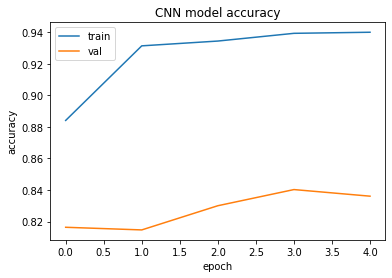

In [28]:
import matplotlib.pyplot as plt
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

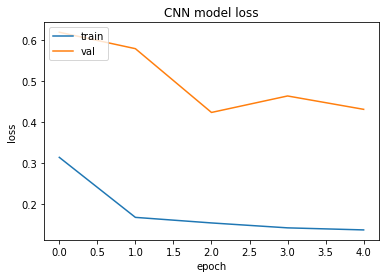

In [29]:
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
cnn_model.save_weights('/content/drive/MyDrive/checkpoint/cnn1d_2.ckpt')

In [ ]:
hist_cnn.history['accuracy']

[0.8841359615325928,
 0.9314493536949158,
 0.9344901442527771,
 0.939389169216156,
 0.940077006816864]

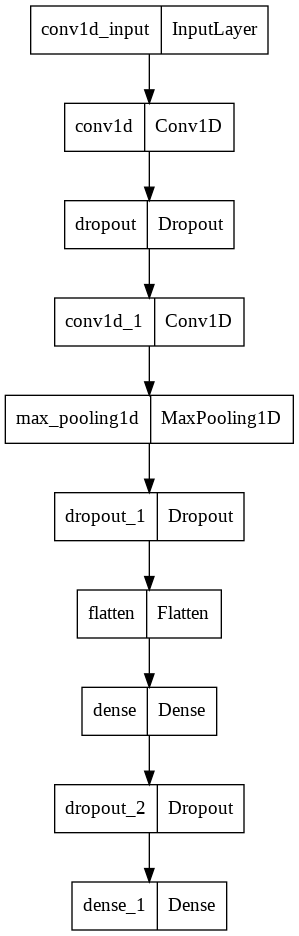

In [ ]:
tf.keras.utils.plot_model(cnn_model, to_file="model.png")